In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
plt.rcParams["figure.figsize"] = (12,4)

# Exercise Johnson-Johnson 

### Q1: what would you conclude if you were to model these data with an AR or MA process?

In [ ]:
df = pd.read_csv('JohnsonJohnson.csv', index_col=0)
df['year']=np.trunc(df['time']).astype(int)
df['quarter'] = np.round((df['time'] - df['year'])*4+1).astype(int)
df['month'] = df['quarter'].map({1: 3, 2: 6, 3:9,4:12})
df['day'] = df['quarter'].map({1: 31, 2: 30, 3:30,4:31})
df['date'] = pd.to_datetime(df[['year','month','day']])

df = df.reset_index(drop = True) # to have the index starting at 0 (more Pythonic)

df.head()

,time,value,year,quarter,month,day,date
0,1960.00,0.71,1960,1,3,31,1960-03-31
1,1960.25,0.63,1960,2,6,30,1960-06-30
2,1960.50,0.85,1960,3,9,30,1960-09-30
3,1960.75,0.44,1960,4,12,31,1960-12-31
4,1961.00,0.61,1961,1,3,31,1961-03-31


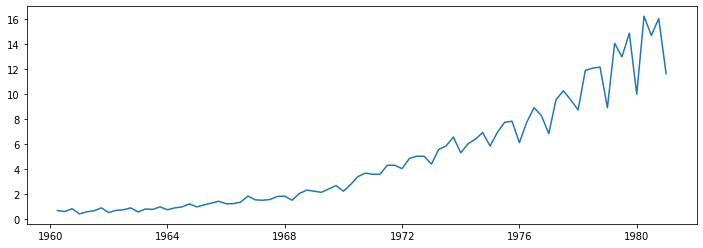

In [ ]:
plt.plot(df['date'],df['value'])

We are clearly not in a stationary situation here: a clear upward trend (mean variation) as well as a change in standard deviation (increasing over time). As it is, AR or MA models would no seem suitable.

### Q2: log-transform this time series: xt' = ln(xt). Then on this log-transformed time series, differentiate it following this logic: x''t = x't-x'(t-1) (use the diff() function from pandas DataFrame; keep in mind the first value of this differenciation will be N/A)

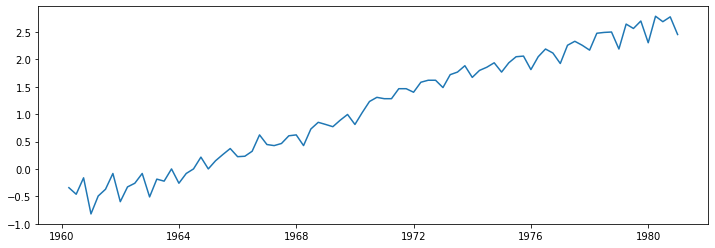

In [ ]:
df['log_val'] = np.log(df['value'])
plt.plot(df['date'],df['log_val'])

We see the log transformation is smoothing the change in variation. The trend is more linear as well, though it is still here (so not yet stationary).

In [ ]:
df['diff_log_val'] = df['log_val'].diff(1)
df.head()

,time,value,year,quarter,month,day,date,log_val,diff_log_val
0,1960.00,0.71,1960,1,3,31,1960-03-31,-0.342490,NaN
1,1960.25,0.63,1960,2,6,30,1960-06-30,-0.462035,-0.119545
2,1960.50,0.85,1960,3,9,30,1960-09-30,-0.162519,0.299517
3,1960.75,0.44,1960,4,12,31,1960-12-31,-0.820981,-0.658462
4,1961.00,0.61,1961,1,3,31,1961-03-31,-0.494296,0.326684


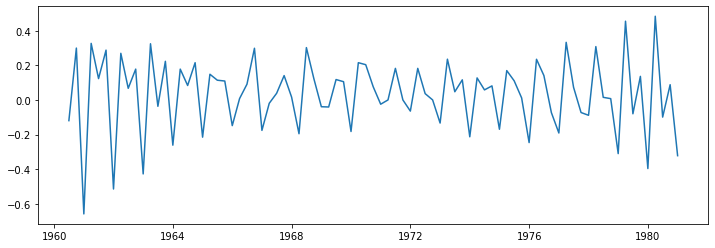

In [ ]:
plt.plot(df['date'],df['diff_log_val'])

### Q3: what do you think of the obtained time series x''t? Try to find a suitable model for it

Differenciation has removed the trend. It is not perfect but we could say that this time series starts to look like coming from a stationary process, therefore we could think of searching for a AR or MA process.

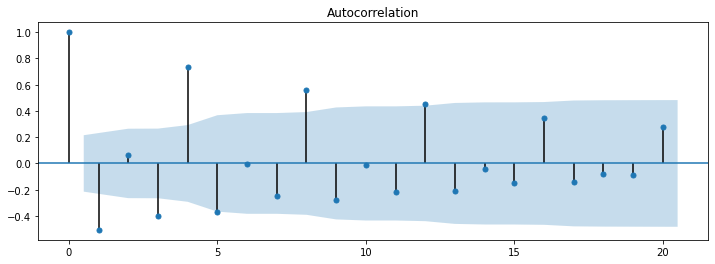

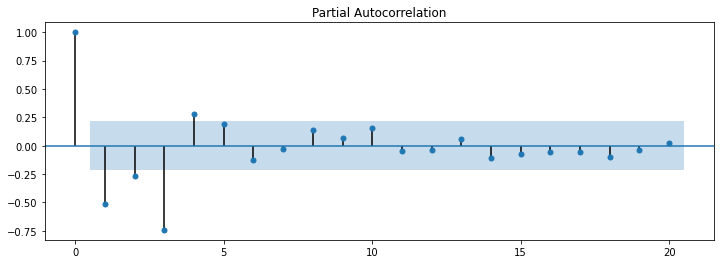

In [ ]:
# note how here you should explicitely discard the first row (being N/A)
fig_acf = plot_acf(df['diff_log_val'].iloc[1:len(df)])
fig_pacf = plot_pacf(df['diff_log_val'].iloc[1:len(df)])

We have some evidence of an AR(4) process, or at least it would be a reasonable model to try at first.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           diff_log_val   No. Observations:                   83
Model:                     ARMA(4, 0)   Log Likelihood                  80.624
Method:                       css-mle   S.D. of innovations              0.088
Date:                Mon, 04 Jan 2021   AIC                           -149.248
Time:                        11:43:06   BIC                           -134.735
Sample:                             0   HQIC                          -143.417
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0384      0.004     10.271      0.000       0.031       0.046
ar.L1.diff_log_val    -0.6834      0.112     -6.085      0.000      -0.904      -0.463
ar.L2.diff_log_val    -0.6104      0.118     -5.167      0.000      -0.842      -0.379
ar.L3.diff_log_val    -0.6226      0.124     -5.018      0.000      -0.866      -0.379
ar.L4.diff_log_val     0.2819      0.118      2.382      0.020       0.050       0.514
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0091           -0.0000j            1.0091           -0.5000
AR.2           -0.0016           -1.0448j            1.0448           -0.2502
AR.3           -0.0016           +1.0448j            1.0448            0.2502
AR.4            3.2211           -0.0000j            3.2211           -0.0000
-----------------------------------------------------------------------------
"""

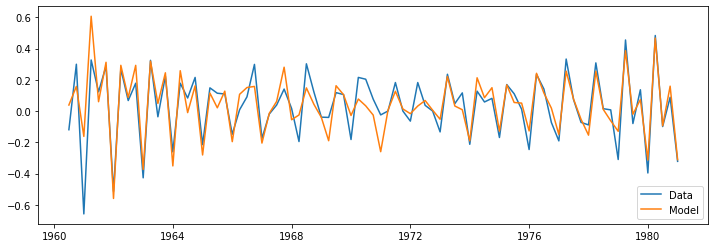

In [ ]:
data = df['diff_log_val'].iloc[1:len(df)]

model = ARIMA(data,(4,0,0))
results = model.fit()
X = results.fittedvalues

plt.plot(df['date'].iloc[1:len(df)], data, label = 'Data')
plt.plot(df['date'].iloc[1:len(df)], X, label = 'Model')
plt.legend()
plt.plot()

results.summary()

### Q4: once you have modelled this new time series, convert it back to analyse the results on the initial one. What do you think of these results?

This model seems quite satisfactory on the differenciated log transformed data, so let see it on the initial data

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


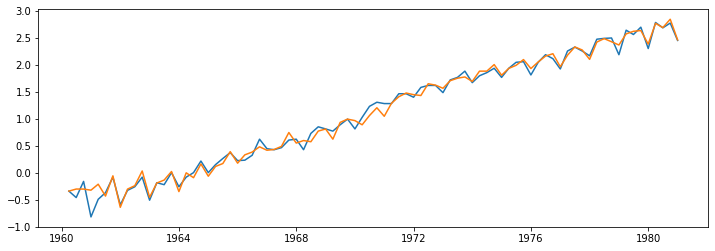

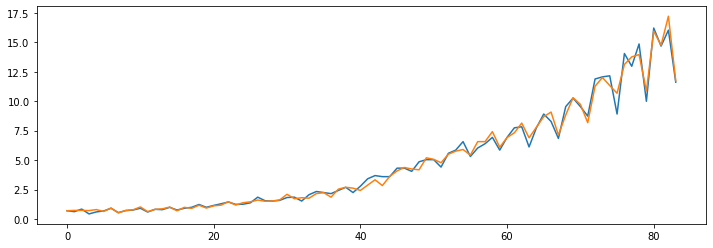

In [ ]:
# we need to differenciate back the series by starting inversing the differenciation

df['pred_log'] = 0 # we define a new column to hold these values
df['pred_log'].iloc[0] = df['log_val'].iloc[0] # we set the first value as being the initial one so we can start from there

#
for i in range(1,len(df)):
  df['pred_log'].iloc[i] = df['log_val'].iloc[i-1] + X.reset_index(drop=True)[i-1] 


plt.plot(df['date'], df['log_val'])
plt.plot(df['date'], df['pred_log'])
plt.show()

plt.plot(df['value'])
plt.plot(np.exp(df['pred_log']))

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


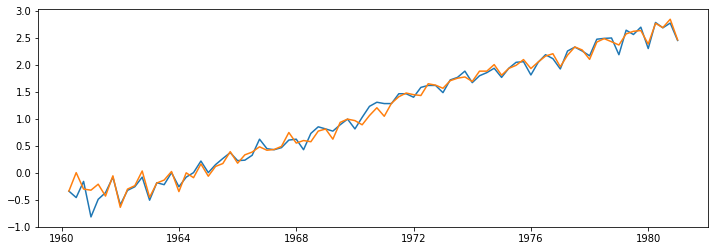

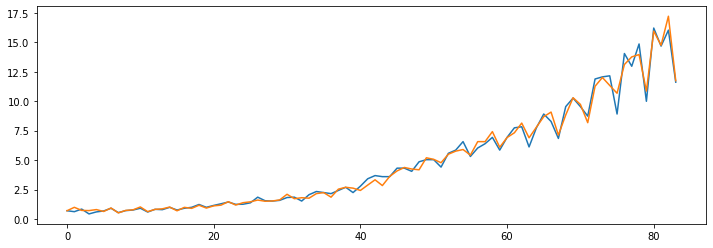

In [ ]:
# we need to differenciate back the series by starting inversing the differenciation

df['pred_log'] = 0 # we define a new column to hold these values
df['pred_log'].iloc[0] = df['log_val'].iloc[0] # we set the first value as being the initial one so we can start from there

# x"t = x't - x'(t-1) so x'(t) = x''t + x'(t-1)
for i in range(1,len(X)):
  df['pred_log'].iloc[i+1] = X[i+1] + df['log_val'].iloc[i] 

# visualise the log transformed series
plt.plot(df['date'], df['log_val'])
plt.plot(df['date'], df['pred_log'])
plt.show()

# transform back the series by taking the exponential
plt.plot(df['value'])
plt.plot(np.exp(df['pred_log']))

The result looks good. However you should not be confused with what you see here. It is not a forecast but a model fitting, where all predicted point is based on real past values (so it should not be too far off in any case)

# Exercise 7 mid-term : forecasting

In [ ]:
df = pd.read_csv('melsyd.csv', index_col = 0)
date = np.array('1987-07-01', dtype=np.datetime64)
df['date'] = date + np.arange(0,len(df)*7,7)
df.head()

,First.Class,Business.Class,Economy.Class,date
1,1.912,NaN,20.167,1987-07-01
2,1.848,NaN,20.161,1987-07-08
3,1.856,NaN,19.993,1987-07-15
4,2.142,NaN,20.986,1987-07-22
5,2.118,NaN,20.497,1987-07-29


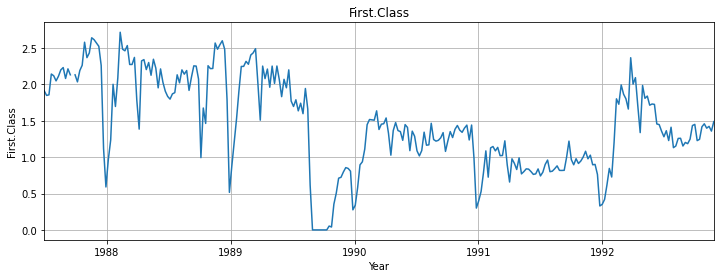

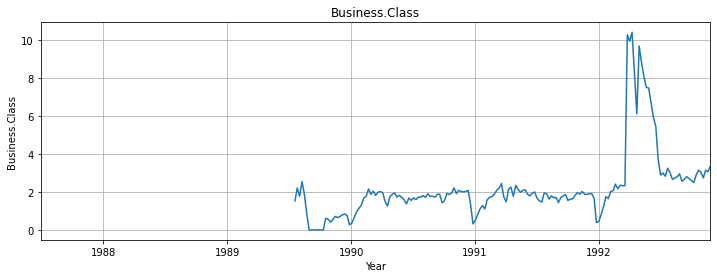

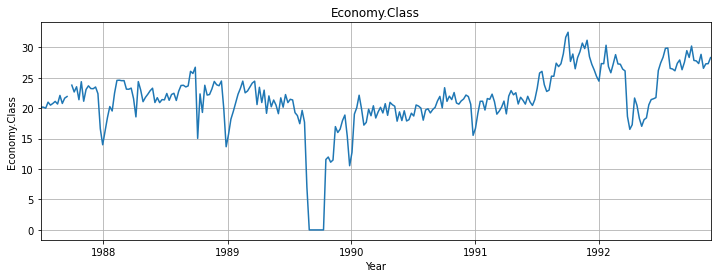

In [ ]:
# to plot all charts
# see here as we have forced to keep the same x values for all charts with xlim (as we have some empty cells on business class)
for i in df.columns[:-1]:
  plt.plot(df['date'], df[i])
  plt.ylabel(i)
  plt.xlabel('Year')
  plt.xlim(df['date'].iloc[0],df['date'].iloc[len(df)-1])
  plt.grid(True)
  plt.title(i)
  plt.show()

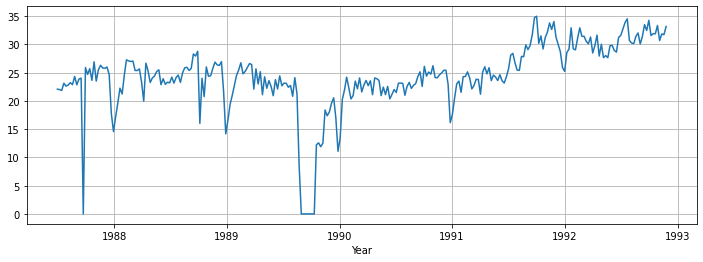

In [ ]:
# we can also plot the total of seats each week

df['All.Class'] = df['Economy.Class'].fillna(0)+df['First.Class'].fillna(0)+df['Business.Class'].fillna(0)
plt.plot(df['date'], df['All.Class'])
plt.xlabel('Year')
plt.grid(True)
plt.show()

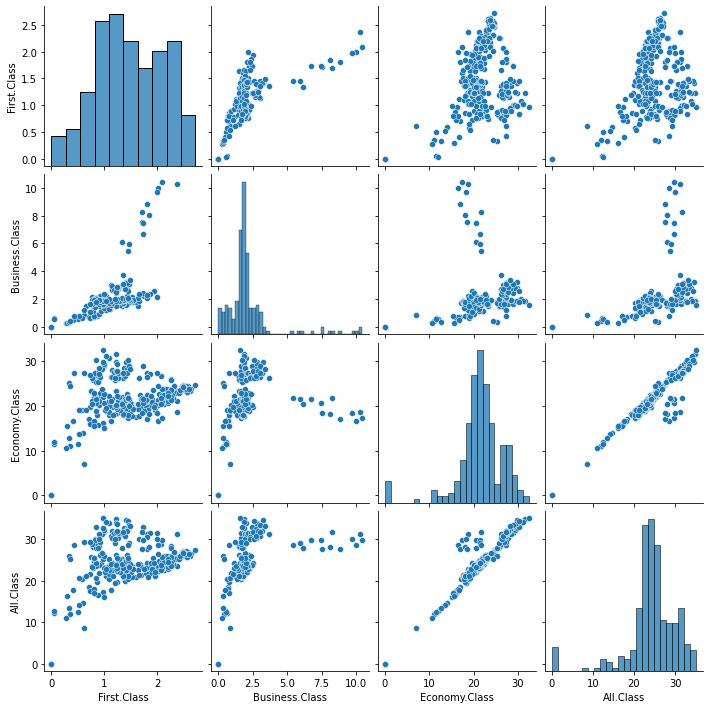

In [ ]:
# a pairplot would be useful to see potential interactions between the time series
sns.pairplot(df)

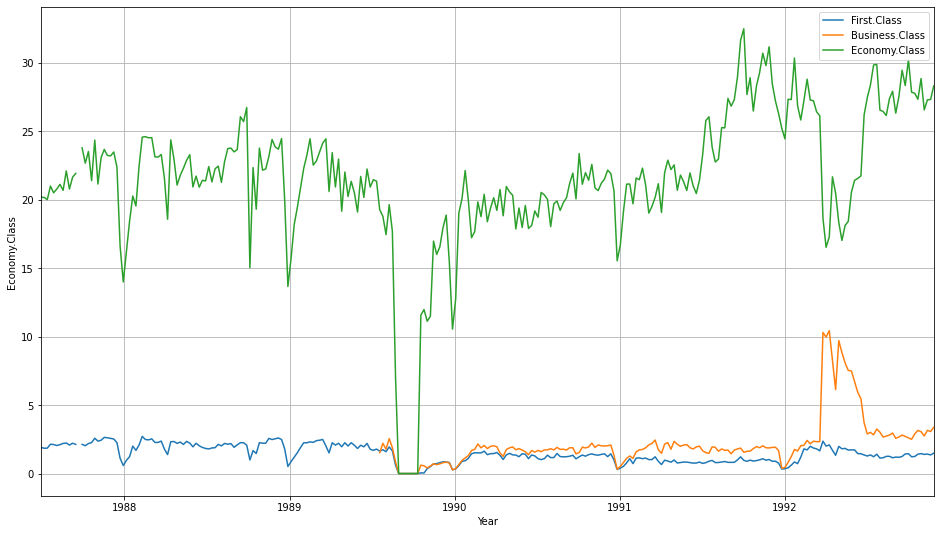

In [ ]:
# remark: can always be interesting to plot all your data on one chart, some phenomenon can appear more quickly

plt.figure(figsize=(16,9))

for i in df.columns[:-2]:
  plt.plot(df['date'], df[i], label = i)
  plt.ylabel(i)
  plt.xlabel('Year')
  plt.xlim(df['date'].iloc[0],df['date'].iloc[len(df)-1])
  plt.legend()
  plt.grid(True)

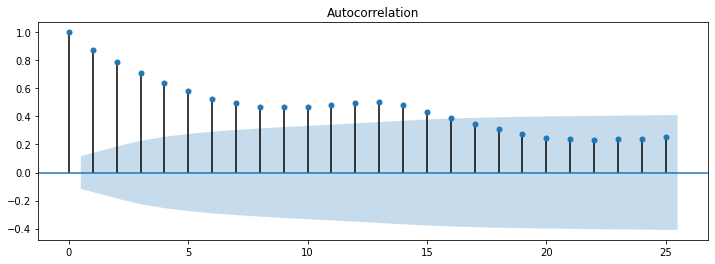

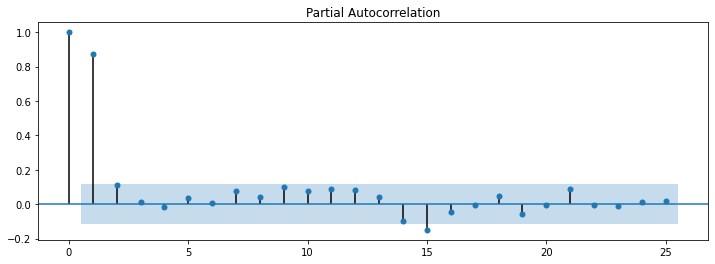

In [ ]:
fig = plot_acf(df['First.Class'].fillna(0))
fig = plot_pacf(df['First.Class'].fillna(0))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            First.Class   No. Observations:                  283
Model:                     ARMA(2, 0)   Log Likelihood                 -73.181
Method:                       css-mle   S.D. of innovations              0.313
Date:                Mon, 04 Jan 2021   AIC                            154.362
Time:                        07:19:27   BIC                            168.944
Sample:                             0   HQIC                           160.209
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.4697      0.156      9.445      0.000       1.165       1.775
ar.L1.First.Class     0.7733      0.059     13.125      0.000       0.658       0.889
ar.L2.First.Class     0.1107      0.059      1.879      0.061      -0.005       0.226
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1151           +0.0000j            1.1151            0.0000
AR.2           -8.0977           +0.0000j            8.0977            0.5000
-----------------------------------------------------------------------------
"""

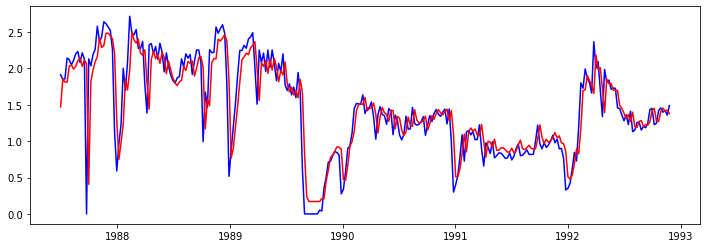

In [ ]:
model = ARIMA(df['First.Class'].fillna(0),(2,0,0))
results = model.fit()

plt.plot(df['date'],df['First.Class'].fillna(0), color='blue')
plt.plot(df['date'],results.fittedvalues, color='red')

results.summary()

# ARIMA, SARIMA and forecasting

### Simulating an ARMA(2,2) process

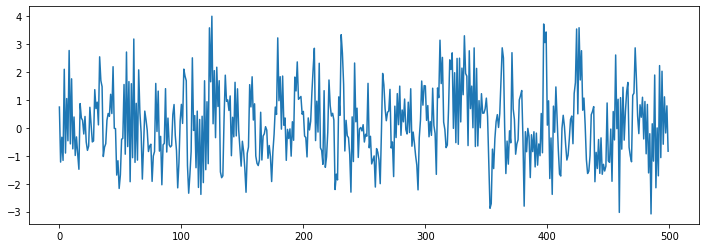

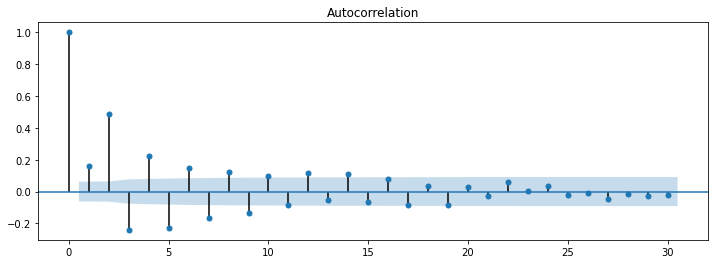

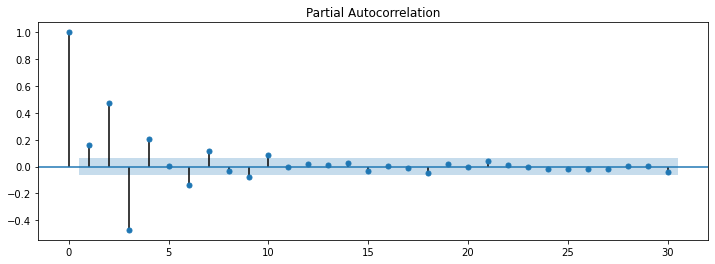

In [ ]:
ar_coeff = np.array([1,0.5,-0.3])
ma_coeff = np.array([1,0.9,0.5])

X = arma_generate_sample(ar_coeff,ma_coeff,1000)

plt.plot(X[0:500])
acf = plot_acf(X)
pacf = plot_pacf(X)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(2, 2)   Log Likelihood               -1413.850
Method:                       css-mle   S.D. of innovations              0.994
Date:                Mon, 04 Jan 2021   AIC                           2839.699
Time:                        07:08:04   BIC                           2869.146
Sample:                             0   HQIC                          2850.891
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0271      0.063      0.429      0.668      -0.097       0.151
ar.L1.y       -0.5192      0.041    -12.684      0.000      -0.599      -0.439
ar.L2.y        0.2765      0.042      6.652      0.0

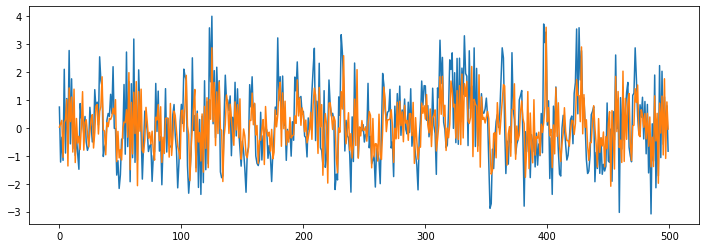

In [ ]:
#fitting a model
model = ARMA(X,(2,2))
result = model.fit()
plt.plot(X[0:500])
plt.plot(result.fittedvalues[0:500])
print(result.summary())

In [ ]:
#calculating the AIC for various combinations

name = []
aic = []
error = False

for p in range(0,5):
  for q in range(0,5):

    error = False
    
    model = ARMA(X,(p,q))

    # depending on the model fitting we might find some coefficients implying stationarity which leas in an error, so we discard these cases
    try:
      ARMA(X,(p,q)).fit()
    except Exception:
      error = True
        
    if(error == False):
      name.append(str([p,q]))
      result = model.fit() 
      aic.append(result.aic)

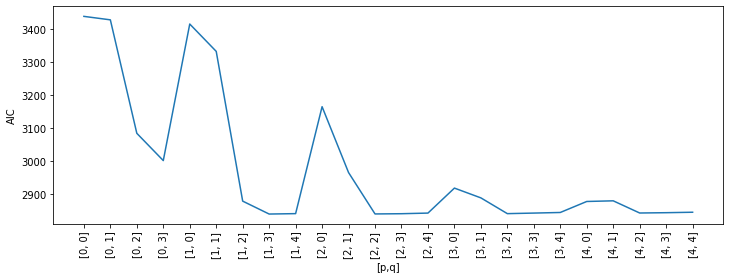

In [ ]:
#plotting the results

plt.plot(name,aic)
plt.xticks(rotation=90)
plt.ylabel('AIC')
plt.xlabel('[p,q]')
plt.show()

### Same as before using differenciation in ARIMA

We have done the differenciation manually but we can use ARIMA to do it for us

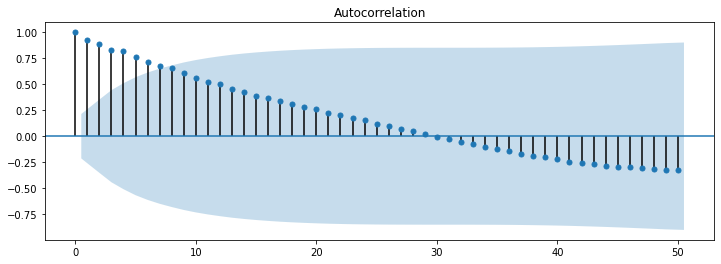

In [ ]:
fig = plot_acf(df['value'], lags = 50)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.log_val   No. Observations:                   83
Model:                 ARIMA(4, 1, 0)   Log Likelihood                  80.624
Method:                       css-mle   S.D. of innovations              0.088
Date:                Sun, 03 Jan 2021   AIC                           -149.248
Time:                        20:56:26   BIC                           -134.735
Sample:                             1   HQIC                          -143.417
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0384      0.004     10.271      0.000       0.031       0.046
ar.L1.D.log_val    -0.6834      0.112     -6.085      0.000      -0.904      -0.463
ar.L2.D.log_val    -0.6104      0.118     -5.167      0.000      -0.842      -0.379
ar.L3.D.log_val    -0.6226      0.124     -5.018      0.000      -0.866      -0.379
ar.L4.D.log_val     0.2819      0.118      2.382      0.020       0.050       0.514
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0091           -0.0000j            1.0091           -0.5000
AR.2           -0.0016           -1.0448j            1.0448           -0.2502
AR.3           -0.0016           +1.0448j            1.0448            0.2502
AR.4            3.2211           -0.0000j            3.2211           -0.0000
-----------------------------------------------------------------------------
"""

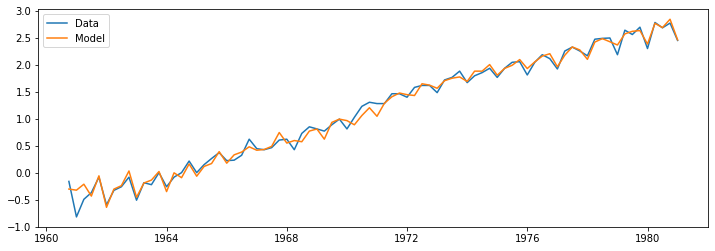

In [ ]:
data = df['log_val']

model = ARIMA(data,(4,1,0))
results = model.fit()

#we use here predict rather than fittedvalues (fitted values gives you the results on the differentiated series)
X = results.predict(typ='levels') #without the argument typ='level' give same result as fittedvalues

plt.plot(df['date'].iloc[2:len(df)], data[2:len(data)], label = 'Data')
plt.plot(df['date'].iloc[2:len(df)], X, label = 'Model')
plt.legend()
plt.plot()

results.summary()

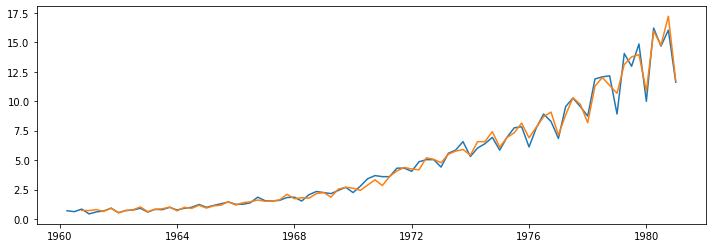

In [ ]:
# transform back the series by taking the exponential
plt.plot(df['date'], df['value'])
plt.plot(df['date'].iloc[2:len(df)], np.exp(X))

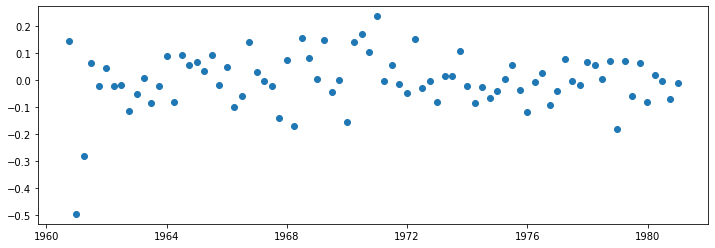

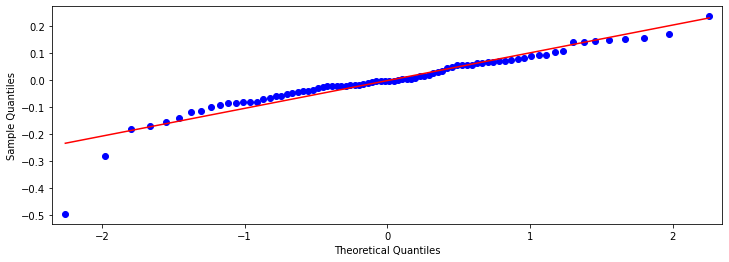

In [ ]:
# residual checking on the log data
res = df['log_val'][2:len(data)] - X

plt.scatter(df['date'].iloc[2:len(df)],res)
fig = qqplot(res, line = 's')

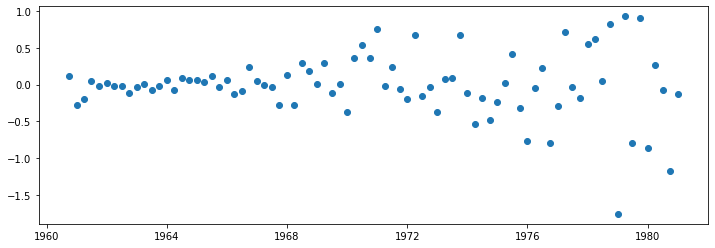

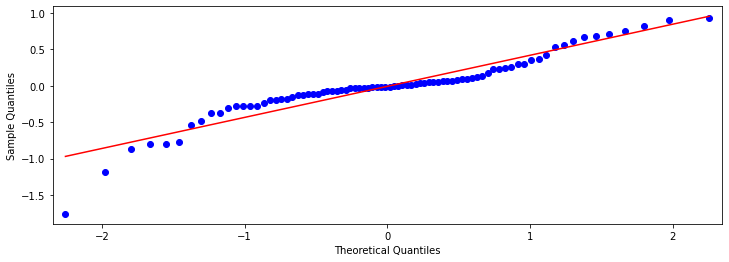

In [ ]:
# residual checking on the final results
res = df['value'].iloc[2:len(df)] - np.exp(X)

plt.scatter(df['date'].iloc[2:len(df)],res)
fig = fig = qqplot(res, line = 's')

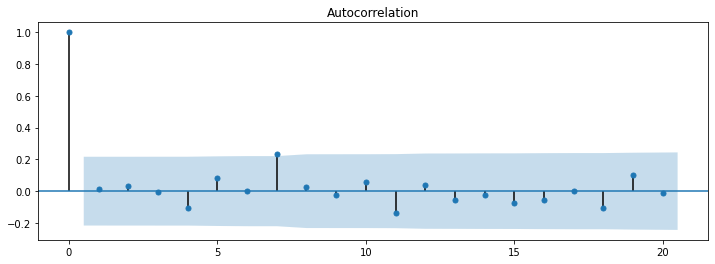

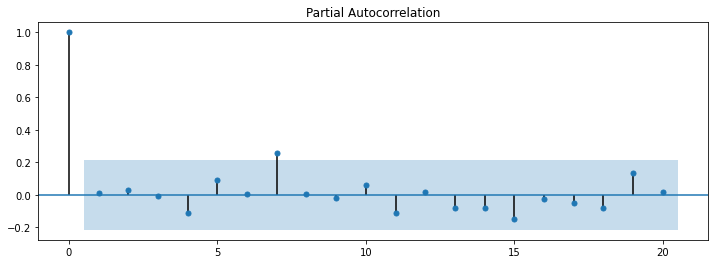

In [ ]:
f = plot_acf(res)
f = plot_pacf(res)

### Forecasting

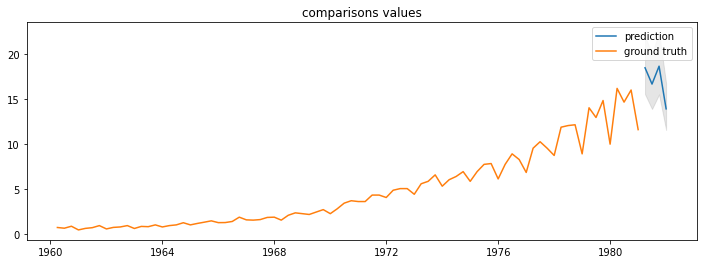

In [ ]:
window = 4

# we create the relevant dates of the forecasted window in date format. Must be more elegant way but this works fast

dates_fcst = pd.DataFrame(df['time'].iloc[-1] + np.arange(0.25,0.25*(window+1),0.25),columns=['time'])

dates_fcst['year']=np.trunc(dates_fcst['time']).astype(int)
dates_fcst['quarter'] = np.round((dates_fcst['time'] - dates_fcst['year'])*4+1).astype(int)
dates_fcst['month'] = dates_fcst['quarter'].map({1: 3, 2: 6, 3:9,4:12})
dates_fcst['day'] = dates_fcst['quarter'].map({1: 31, 2: 30, 3:30,4:31})
dates_fcst['date'] = pd.to_datetime(dates_fcst[['year','month','day']])


# we forecast on the defined window
x_log_pred = results.forecast(window)

plt.plot(dates_fcst['date'],np.exp(x_log_pred[0]),label = 'prediction')

plt.plot(df['date'],df['value'],label = 'ground truth')
plt.title('comparisons values')
plt.fill_between(dates_fcst['date'], np.exp(x_log_pred[2][:,0]), np.exp(x_log_pred[2][:,1]), color='grey', alpha=0.2)
plt.legend()

### Validation

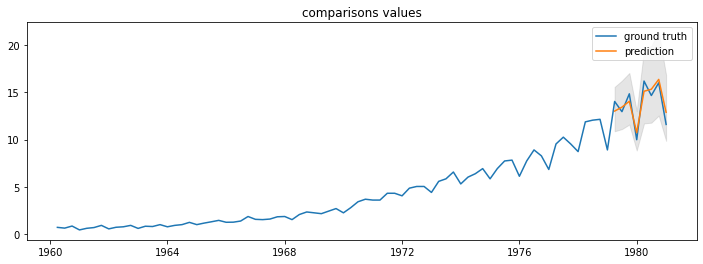

In [ ]:
# we define the indicesof train and val
train = len(df) - 2*window
val = len(df)

model_train = ARIMA(df['log_val'].iloc[0:train],(4,1,0))
results_train = model_train.fit()

results_train.summary()

start = train
end = val

x_log_pred_val = results_train.forecast(val-train)

plt.plot(df['date'].iloc[0:val],df['value'].iloc[0:val],label = 'ground truth')
plt.plot(df['date'].iloc[train:val],np.exp(x_log_pred_val[0]),label = 'prediction')
plt.fill_between(df['date'].iloc[train:val], np.exp(x_log_pred_val[2][:,0]), np.exp(x_log_pred_val[2][:,1]), color='grey', alpha=0.2)
plt.title('comparisons values')
plt.legend()

In [ ]:
# residuals
res = df['value'].iloc[train:val] - np.exp(x_log_pred_val[0])

# RMSE is a good KPI as well for both measuring accuracy and to compare models
rmse = np.sqrt(np.sum((res)**2)/(val-train))
print("RMSE = " + str(rmse))

mape = np.sum(np.abs((res)/df['value'].iloc[train:val]))/(val-train)
print("MAPE = " + str(mape))

RMSE = 0.8516132825475661
MAPE = 0.0601159324745589


### SARIMA

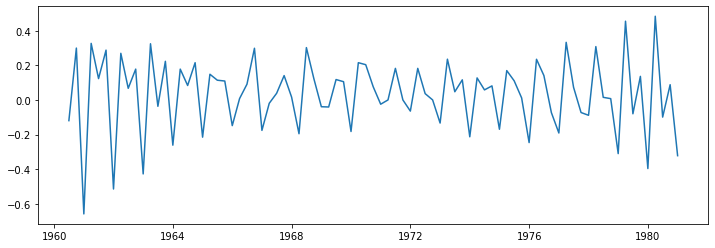

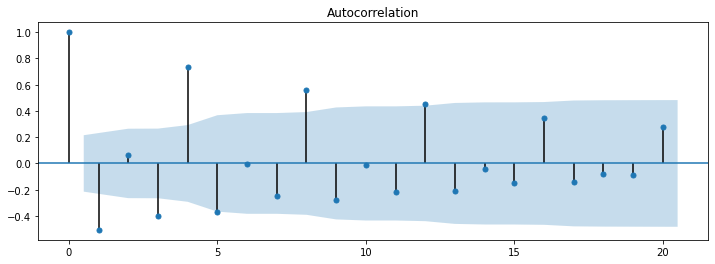

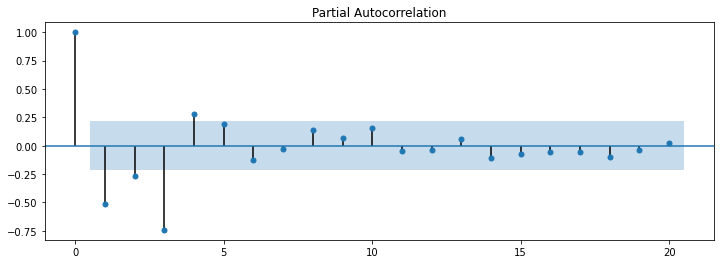

In [ ]:
# remember the acf and pacf of our differentiated log transform

plt.plot(df['date'],df['diff_log_val'])
fig_acf = plot_acf(df['diff_log_val'].iloc[1:len(df)])
fig_pacf = plot_pacf(df['diff_log_val'].iloc[1:len(df)])

The ACF suggest seasonalitty (every 4 quarter). So we could differentiate again to remove it

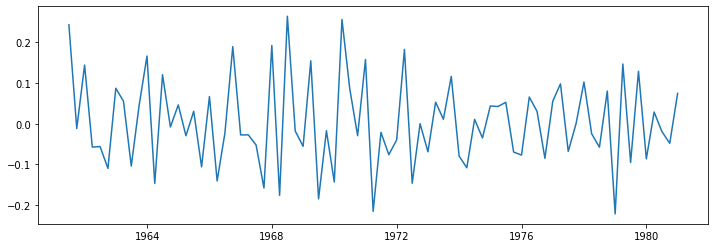

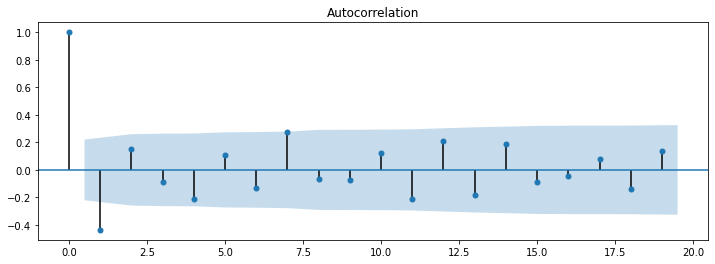

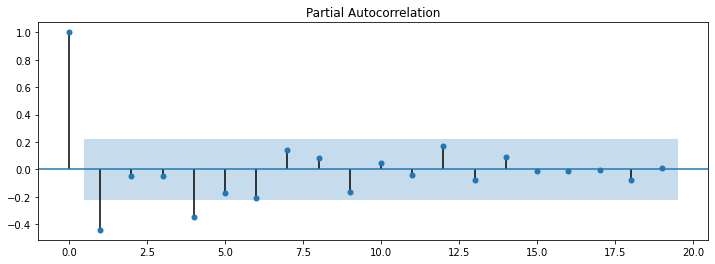

In [ ]:
plt.plot(df['date'],df['diff_log_val'].diff(4))

fig_acf = plot_acf(df['diff_log_val'].diff(4).iloc[5:len(df)])
fig_pacf = plot_pacf(df['diff_log_val'].diff(4).iloc[5:len(df)])

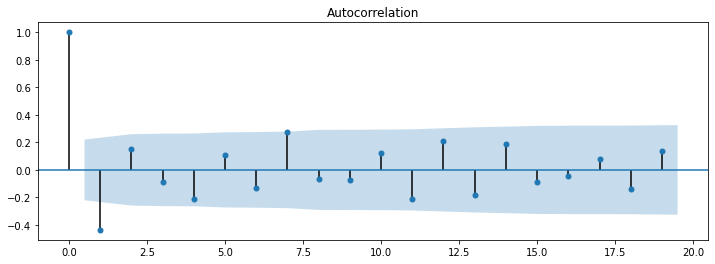

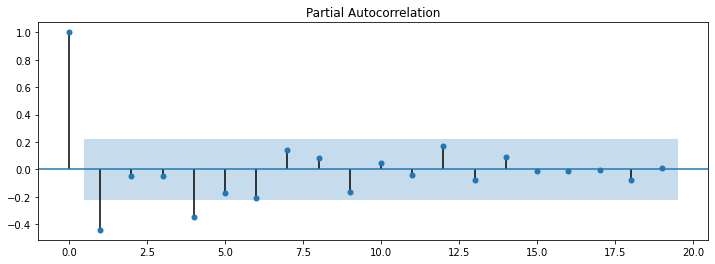

In [ ]:
fig_acf = plot_acf(df['diff_log_val'].diff(4).iloc[5:len(df)])
fig_pacf = plot_pacf(df['diff_log_val'].diff(4).iloc[5:len(df)])

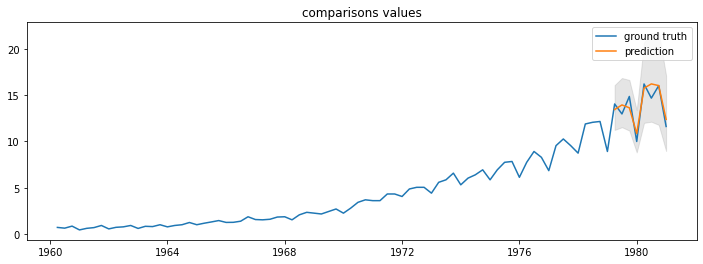

In [ ]:
window = 4

train = len(df) - 2*window
val = len(df)

model_train = SARIMAX(df['log_val'].iloc[0:train],order = (0,1,1),seasonal_order= (1,1,0,4))
results_train = model_train.fit()
#X = results_john_train.predict(typ='levels')

#fig = results_john_train.plot_predict()

results_train.summary()

x_log_pred_val = results_train.forecast(val-train)

# note: with SARIMAX, forecast does not give the confidence interval. You should instead use get_forecast() and then conf_int
low_conf = results_train.get_forecast(val-train).conf_int()['lower log_val']
high_conf = results_train.get_forecast(val-train).conf_int()['upper log_val']

plt.plot(df['date'].iloc[0:val],df['value'].iloc[0:val],label = 'ground truth')
plt.plot(df['date'].iloc[train:val],np.exp(x_log_pred_val),label = 'prediction')
plt.fill_between(df['date'].iloc[train:val], np.exp(low_conf), np.exp(high_conf), color='grey', alpha=0.2)
plt.title('comparisons values')
plt.legend()

In [ ]:
# residuals
res = df['value'].iloc[train:val] - np.exp(x_log_pred_val)

# RMSE is a good KPI as well for both measuring accuracy and to compare models
rmse = np.sqrt(np.sum((res)**2)/(val-train))
print("RMSE = " + str(rmse))

mape = np.sum(np.abs((res)/df['value'].iloc[train:val]))/(val-train)
print("MAPE = " + str(mape))

RMSE = 0.9145750500303207
MAPE = 0.0606320591195394


Though the model is best we are slightly lower than our simple ARIMA(4,1,0) earlier on. Let's check the residuals on the full data (as it is what we did)

[]

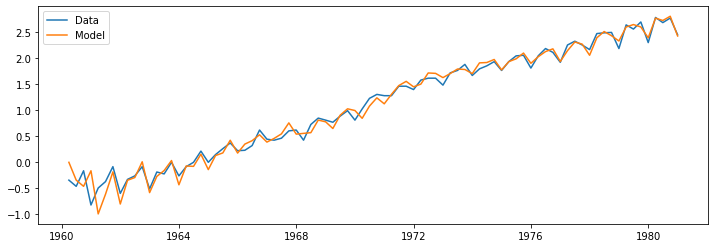

In [ ]:
model = SARIMAX(df['log_val'],order = (0,1,1),seasonal_order= (1,1,0,4))
results = model.fit()
#X = results_john_train.predict(typ='levels')

#fig = results_john_train.plot_predict()

results.summary()

X = results.predict(typ='levels') #without the argument typ='level' give same result as fittedvalues

plt.plot(df['date'], df['log_val'], label = 'Data')
plt.plot(df['date'], X, label = 'Model')
plt.legend()
plt.plot()

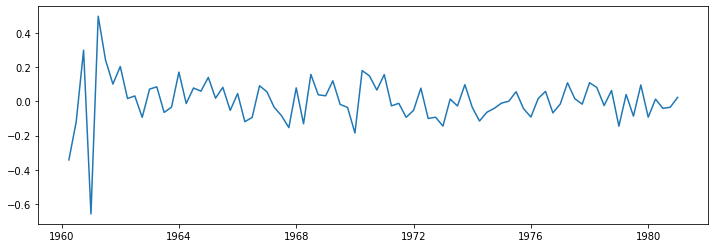

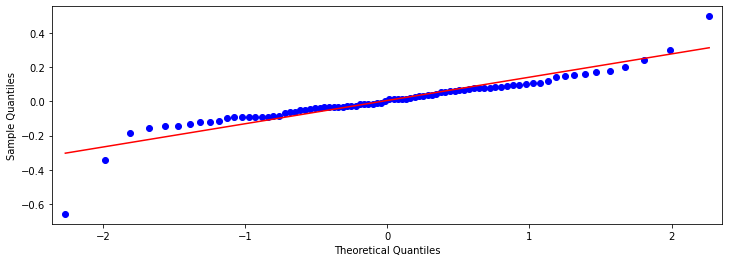

In [ ]:
res = df['log_val'] - X
plt.plot(df['date'],res)
fig = qqplot(res, line = 's')

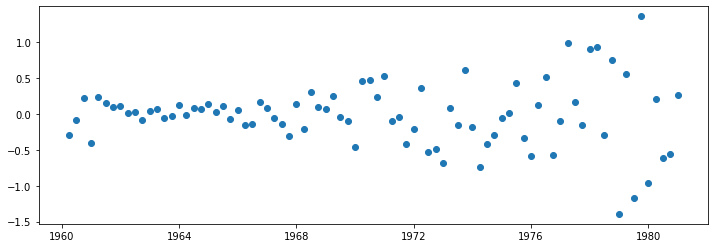

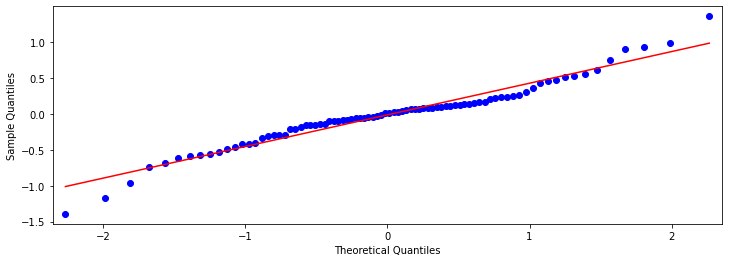

In [ ]:
res = df['value'] - np.exp(X)

plt.scatter(df['date'],res)
fig = qqplot(res, line = 's')